# OTTO - EDA + Basic LSTM Model

The Load-in is based on the fantastic notebook: https://www.kaggle.com/code/columbia2131/otto-fast-dataframe-loading-in-parquet-format

In [1]:
import os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from glob import glob
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
%%time
files = sorted(glob('../input/otto-chunk-data-inparquet-format/train_parquet/*'))[:5]
dfs = []

for path in tqdm(files):
    dfs.append(pd.read_parquet(path))

dfs = pd.concat(dfs).reset_index(drop=True)

100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


CPU times: user 3.89 s, sys: 1.63 s, total: 5.51 s
Wall time: 6.32 s


In [3]:
dfs

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
22547351,499999,218792,1659716490375,clicks
22547352,499999,687266,1659716504581,clicks
22547353,499999,218792,1659716518923,clicks
22547354,499999,862274,1659716743631,clicks


# Basic EDA

## Let convert the timestamps to readable time

In [4]:
dfs['ts_conv'] = pd.to_datetime(dfs['ts'], unit='ms')

Lets see which time we are looking at!

In [5]:
print(f'Years: {dfs["ts_conv"].dt.year.unique()}, \n Months:  {dfs["ts_conv"].dt.month.unique()} \n Days: {dfs["ts_conv"].dt.day.unique()}  ')

Years: [2022], 
 Months:  [7 8] 
 Days: [31  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 12]  


**So we have data from the 31.07.2022 to 28.08.2022**

In [6]:
print(f'Minimum timestep: {dfs["ts_conv"].min()}, Maximum timestep {dfs["ts_conv"].max()}')  

Minimum timestep: 2022-07-31 22:00:00.025000, Maximum timestep 2022-08-28 21:59:59.941000


# Lets look at the Session lengths

In [7]:
dfs_grouped = dfs.groupby('session')['ts_conv'].agg([min,max])
dfs_grouped['diff'] = dfs_grouped['max']-dfs_grouped['min']

# Plotting the Session length in days 

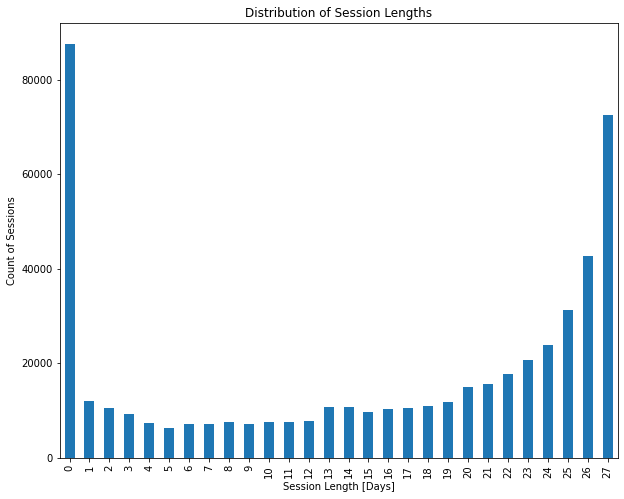

In [8]:
dfs_grouped['diff'].dt.days.sort_values().value_counts(sort=False).plot(kind='bar', figsize=(10,8), title='Distribution of Session Lengths')
plt.xlabel('Session Length [Days]')
plt.ylabel('Count of Sessions')
plt.show()

That is a very peculiar distribution. The two highest counts are for the lowest and highest Session length. Lets examine what is going on!

In [9]:
idx_0 = dfs_grouped.query('diff.dt.days == 0').index.to_list()
idx_27 = dfs_grouped.query('diff.dt.days == 27').index.to_list()


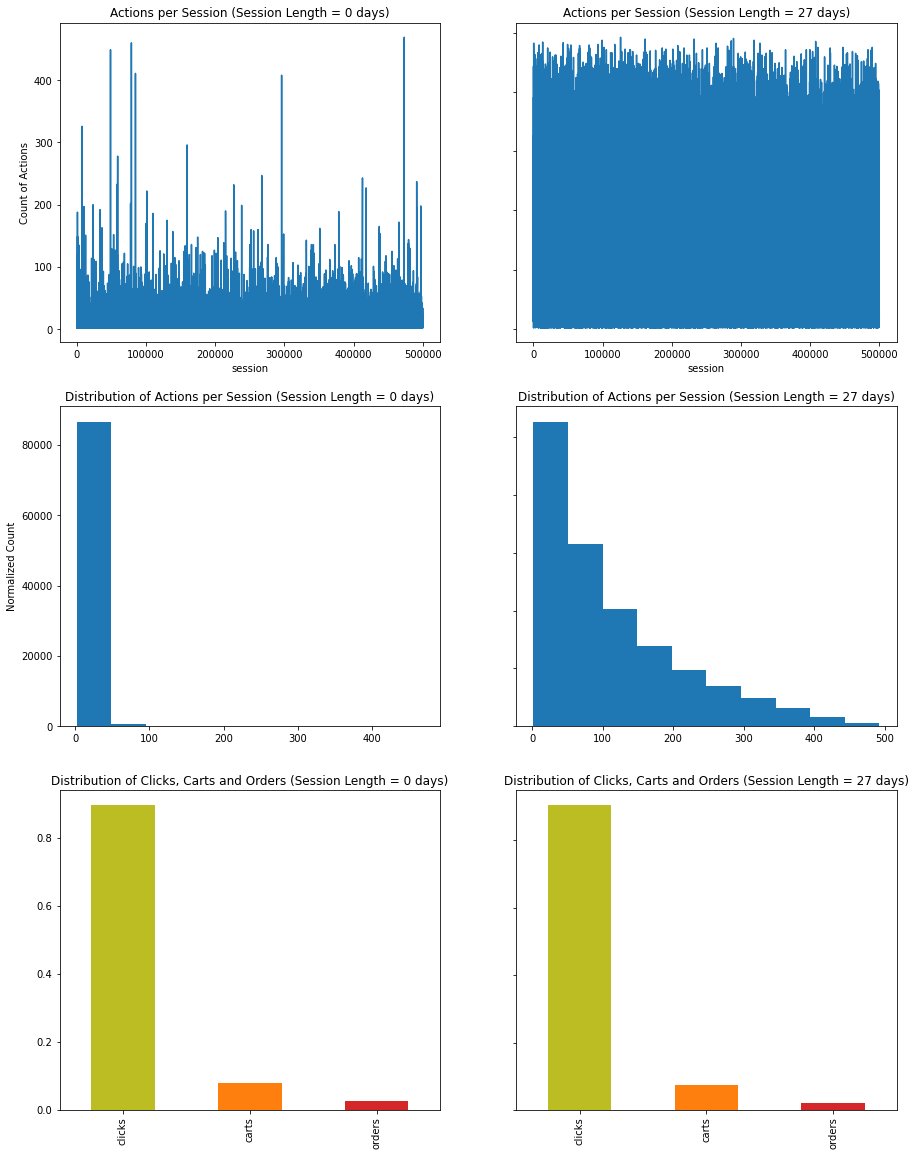

In [10]:
colors = ['tab:olive', 'tab:orange', 'tab:red']

fig, axs = plt.subplots(3, 2, figsize=(15,20))
dfs.query('session in @idx_0').groupby('session').size().plot.hist(ax=axs[1,0])
dfs.query('session in @idx_0').type.value_counts(normalize=True).plot(kind='bar',ax=axs[2,0], color=colors)
dfs.query('session in @idx_0').groupby('session').size().plot(ax=axs[0,0])
dfs.query('session in @idx_27').type.value_counts(normalize=True).plot(kind='bar',ax=axs[2,1],  color=colors)
dfs.query('session in @idx_27').groupby('session').size().plot(ax=axs[0,1], sharey = axs[0,0])
dfs.query('session in @idx_27').groupby('session').size().plot.hist(ax=axs[1,1])
axs[0,0].set_ylabel('Count of Actions')
axs[1,0].set_ylabel('Normalized Count')
axs[0,0].set_title('Actions per Session (Session Length = 0 days)')
axs[0,1].set_title('Actions per Session (Session Length = 27 days)')
axs[1,0].set_title('Distribution of Actions per Session (Session Length = 0 days)')
axs[1,1].set_title('Distribution of Actions per Session (Session Length = 27 days)')
axs[2,0].set_title('Distribution of Clicks, Carts and Orders (Session Length = 0 days)')
axs[2,1].set_title('Distribution of Clicks, Carts and Orders (Session Length = 27 days)')
plt.show()

# axs[1].set_title('Session Length = 27 days')
# axs[0].set_ylabel('Normalized Count')



> So there is seemingly **no difference in the distributions** of <span style="color:olive"> Clicks</span>, <span style="color:orange">Carts</span>, <span style="color:red">Orders</span> whether the session lasts 27 or 0 days <br>
> However the distribution of <span style="color:blue">Actions</span> shows, that all **sessions lasting shorter than 1 day had less than 50 actions** while for longer session the distribution looks more like a normal distribution 

# What are the Last actions within a Session? 

In [11]:
list_last = [i[-1] for i in dfs.groupby('session').agg({'type':lambda x: list(x)}).type.to_list()]
list_all = [item for sublist in dfs.groupby('session').agg({'type':lambda x: list(x)}).type.to_list() for item in sublist]


## Lets see how likely is it that a Session ends with an order? 


In [12]:
for i in ['clicks', 'carts', 'orders']:
    print(f'It is {np.round((list_last.count(i)*len(list_all))/(list_all.count(i)*len(list_last)), 1)} times likely that the last actions were {i}')

It is 1.0 times likely that the last actions were clicks
It is 0.5 times likely that the last actions were carts
It is 1.8 times likely that the last actions were orders


> So compared to the average probabilites of clicks, carts and orders, it is half as likely that a session ends with a cart but almost twice as likely to end as an order! 

## Example of a session ending with an order

In [13]:
var = list_last.index('orders')
dfs.query('session==@var')['type'].to_list()[-5:]

['clicks', 'clicks', 'clicks', 'clicks', 'orders']

## Intersections of Article Ids of Different Sessions

As our goal is to predict future clicked Article Ids it is interesting to look at how different sets of article ids of different sessions compare

In [14]:
df_aid = dfs.groupby('session').agg({'aid':lambda x: list(x), 'type':lambda x: list(x)})

In [15]:

from tqdm import tqdm
# only look at first 1000 sesssions for simplicity 
dim = 1000
test = df_aid.aid[:dim].to_list()
heat_arr = np.zeros((dim, dim))
y1  = [np.ones(dim)*i for i in range(dim)]


for i in tqdm(range(dim)):
    for counter2, j in enumerate(test):
        if test[i] != j: 
            heat_arr[i, counter2] = len(set(test[i]).intersection(set(j)))/len(set(test[i]))

            
            


100%|██████████| 1000/1000 [00:09<00:00, 103.98it/s]


In [16]:
import numpy as np
import plotly.graph_objs as go
from itertools import cycle

fig = go.Figure()
for i, z in enumerate(heat_arr):
    ### to avoid clutter lets only look at a sessions which share atleast 50% of articles with at least one other session
    if np.any(z >= 0.5):
        fig.add_trace(
            go.Scatter3d(
                x = np.arange(dim),
                y = y1[i],
                z = z,
                mode='lines',
            )
        )
fig.update_layout(
    scene = dict(
       xaxis_title='Session Id',  
       yaxis_title='Session Id', 
       zaxis_title='Overlap of Aid'),
    width=700,
    title="Overlap of Article IDs Between Different Sessions",
    margin=dict(r=10, l=10, b=10, t=30))
fig.show()

By visualizing the overlap of only the first 1000 sessions we see that there are patterns of overlapping article Ids between sessions. Notably there are a number of some sessions which share 100% of Article Ids with one another. 


# Building a simple LSTM to predict last Aid within one Session

Long short-term memory (LSTM) is an artificial neural network. Unlike standard feedforward neural networks, LSTM has feedback connections. Such a recurrent neural network (RNN) can process not only single data points (such as images), but also entire sequences of data. <br>
![LSTM](https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/LSTM_cell.svg/1048px-LSTM_cell.svg.png?20200923110354)

![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-25_at_8.54.27_PM.png)

Very nice tutorial on BI-LSTM: https://www.kaggle.com/code/ysthehurricane/next-word-prediction-bi-lstm-tutorial-easy-way

## <u>Objective of this first model</u>: <br>
* Simplest LSTM model (Many-to-one) , which is able to predict the last article Id clicked within one session.
* Not worry about overfitting for now

### Starting With a Subset of the Data 

In [17]:
# start with only a small subset of dfs
dfs1 = dfs.head(750000)
dfs1.aid.nunique()

210692

In [18]:
ids = np.arange(dfs1.aid.nunique())
# shuffling to prevent any correlation between new labels and outcome
np.random.shuffle(ids)

In [19]:
# mapping article id to integer encoding 
map_aid = {i:j for i, j in zip(dfs1.aid.unique(), ids)}

In [20]:
dfs1['aid_id'] = dfs1['aid'].map(map_aid)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
dfs1.head()

,session,aid,ts,type,ts_conv,aid_id
0,0,1517085,1659304800025,clicks,2022-07-31 22:00:00.025,162921
1,0,1563459,1659304904511,clicks,2022-07-31 22:01:44.511,203888
2,0,1309446,1659367439426,clicks,2022-08-01 15:23:59.426,54837
3,0,16246,1659367719997,clicks,2022-08-01 15:28:39.997,172061
4,0,1781822,1659367871344,clicks,2022-08-01 15:31:11.344,104335


## Grouping the Train data by Session 

In [22]:
df_train = dfs1.groupby('session').agg({'aid_id':lambda x: list(x)})

Lets for now only consider session with less than or equal 20 aids

In [23]:
df_train = df_train[df_train.aid_id.map(len) <= 20]
df_train.head()

,aid_id
session,
4,"[113958, 62936, 62936, 199720, 180968, 161938,..."
5,"[29433, 205181, 2647, 46655, 168614, 102004, 1..."
8,"[146190, 161081, 58423, 161081]"
9,"[18760, 18760, 39169, 65070, 65070, 80461, 105..."
10,"[57191, 185603, 202530, 46264, 26311, 63628]"


In [24]:
# Padding to make all lists of same size 
length = max(map(len, df_train.aid_id))
X = np.asarray([[0]*(length-len(xi)) + xi for xi in df_train.aid_id]).astype('int32')
X

array([[     0, 113958,  62936, ...,  27017, 184816,  67715],
       [     0,      0,      0, ...,  35492,  64002,  64002],
       [     0,      0,      0, ..., 161081,  58423, 161081],
       ...,
       [     0,      0,      0, ..., 134050, 134050, 134050],
       [     0,      0,      0, ...,  28157,  28157,  28157],
       [     0,      0,      0, ...,  94050, 112967,  15296]], dtype=int32)

### Train-Test-Split

For now lets set `X = X[:,:-1]` (all except last aid) and `y = x[:,-1]` (last aid) for training the model. 

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_label_train, y_val_train = train_test_split(X[:,:-1], X[:, -1], test_size=0.2, shuffle=True, random_state=42)
y_train = tf.keras.utils.to_categorical(y_label_train, num_classes=dfs1.aid.nunique())
# onehot encoding on labels corresponding to num_classes
y_val = tf.keras.utils.to_categorical(y_val_train, num_classes=dfs1.aid.nunique())
X_train.shape

(4529, 19)

In [26]:
# X_train = np.expand_dims(X_train, axis=2)
# X_val = np.expand_dims(X_val, axis=2)
# X_train.shape, y_label_train.shape

In [27]:
import gc
gc.collect()

46

### BASIC Bidirectional-LSTM Model Architecture

In [28]:
model = tf.keras.Sequential()
# Adding an Embbeding Layer
model.add(layers.Embedding(dfs1.aid.nunique(), 20, input_length=X_train.shape[1]))
model.add(layers.Bidirectional(layers.LSTM(64, dropout=0.2)))
model.add(layers.Dense(dfs1.aid.nunique(), activation='softmax'))

2022-11-05 11:10:28.259102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 11:10:28.260079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 11:10:28.415035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 11:10:28.416011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 11:10:28.416919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 19, 20)            4213840   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               43520     
_________________________________________________________________
dense (Dense)                (None, 210692)            27179268  
Total params: 31,436,628
Trainable params: 31,436,628
Non-trainable params: 0
_________________________________________________________________


In [30]:
from tensorflow.keras.optimizers import RMSprop, Adam

optimizer = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [31]:
history = model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val), verbose=2, batch_size=64)
model.save('./model1.h5')
# # Loadin pre trained model from cache
# recon_model = keras.models.load_model("model1.h5")

2022-11-05 11:10:33.115011: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3816896272 exceeds 10% of free system memory.
2022-11-05 11:10:38.417768: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3816896272 exceeds 10% of free system memory.
2022-11-05 11:10:41.638962: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3


2022-11-05 11:10:45.769500: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-11-05 11:10:53.892975: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 954856144 exceeds 10% of free system memory.
2022-11-05 11:10:55.269294: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 954856144 exceeds 10% of free system memory.


71/71 - 16s - loss: 12.1967 - accuracy: 8.8320e-04 - val_loss: 12.0847 - val_accuracy: 8.8261e-04
Epoch 2/3
71/71 - 7s - loss: 9.2014 - accuracy: 8.8320e-04 - val_loss: 13.2525 - val_accuracy: 8.8261e-04
Epoch 3/3
71/71 - 7s - loss: 8.5624 - accuracy: 4.4160e-04 - val_loss: 13.4457 - val_accuracy: 0.0000e+00


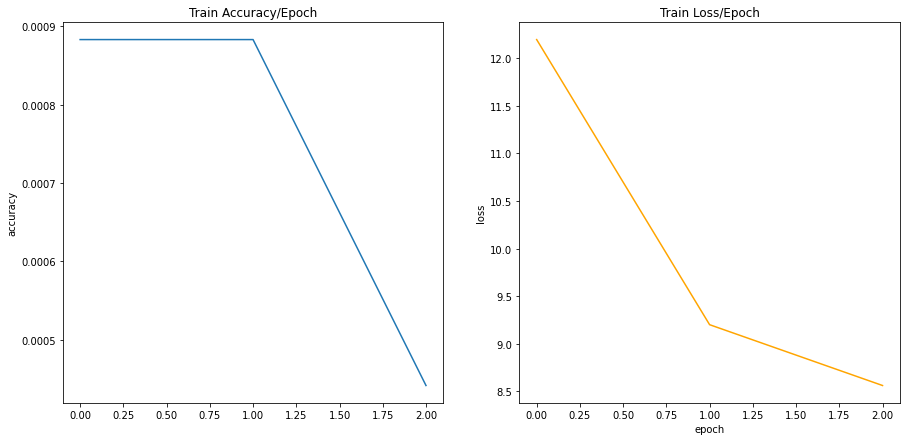

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.plot(history.history['accuracy'])
ax2.plot(history.history['loss'], color='Orange')
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
ax2.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax2.set_ylabel('loss')
ax1.set_title('Train Accuracy/Epoch')
ax2.set_title('Train Loss/Epoch')


plt.show()

In [ ]:
_, acc = model.evaluate(X_train, y_train)

# Some tests

In [ ]:
Next_aid = model.predict(X_train, verbose=0)
fig, axs = plt.subplots(2, 2, figsize=(15,11))
np.random.seed(42)
for i in range(2):
    for j in range(2):
        val = np.random.randint(X_train.shape[0]) 
        max_val = np.where(Next_aid[val] == np.max(Next_aid[val]))
        axs[i,j].plot(Next_aid[val], label='softmax output')
        axs[i,j].plot([y_label_train[val], y_label_train[val]], [1, 0], alpha=0.5, c='red', label='true label')
        axs[i,j].legend()
        axs[i,j].set_title(f'Train Session {val}')
        axs[i,j].annotate(xy=(y_label_train[val],0.1), text=f'Predicted Label:{max_val[0][0]} \n True Label:{y_label_train[val]}', color='red')
        axs[i,j].set_xlabel('Article ID')
        

In [ ]:
print(f'So for now we have a model which has a accuracy of {np.round(acc,3)} on the train data, but is clearly overfitting!')

## Next steps:
* Increase Input sample
* Change Loss function to better fit the competition
* Add dropout
* Number of features (article Ids)?
* Model Validation



## WIP :)